In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
#np.random.seed(123)

# viz
import matplotlib.pyplot as plt

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [3]:
samples = pd.read_csv('../data/TCGA/rna-seq_adeno/meta/gdc_sample_sheet.2020-01-27.tsv', sep="\t")
# get file type
samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
samples['Project ID'].value_counts()

TCGA-LUSC    301
TCGA-LUAD    287
CPTAC-3      209
Name: Project ID, dtype: int64

Samples with RNAseq adjacent normal tissue

In [4]:
samples['Sample Type'].value_counts()

Primary Tumor                               558
Solid Tissue Normal                         206
Primary Tumor, Primary Tumor                 29
Solid Tissue Normal, Solid Tissue Normal      4
Name: Sample Type, dtype: int64

In [5]:
samples.loc[samples['Sample Type']=='Primary Tumor, Primary Tumor', 'Sample Type'] = 'Primary Tumor'
samples.loc[samples['Sample Type']=='Solid Tissue Normal, Solid Tissue Normal', 'Sample Type'] = 'Solid Tissue Normal'

In [6]:
samples['Sample Type'].value_counts()

Primary Tumor          587
Solid Tissue Normal    210
Name: Sample Type, dtype: int64

In [7]:
# all cases with adjacent normal tissue
cases = samples[samples['Sample Type']=='Solid Tissue Normal']['Case ID']

In [8]:
# disparity in cases
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') 
        & (samples['data']=='FPKM')]['Case ID'].nunique()
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') 
        & (samples['data']=='FPKM')]['Case ID'].nunique()

176

210

In [9]:
# divide, join, subset
case_tumor = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') & 
                     (samples['data']=='FPKM')]
case_norm = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') & 
                    (samples['data']=='FPKM')]
cases = pd.merge(case_tumor['Case ID'], case_norm['Case ID'])['Case ID']
cases.shape

(187,)

In [10]:
case_tumor = case_tumor[case_tumor['Case ID'].isin(cases)]
case_norm = case_norm[case_norm['Case ID'].isin(cases)]
# random shuffle so test dataset loader has random order
cases = pd.concat([case_tumor, case_norm]).sample(frac=1)

In [11]:
case_tumor.shape
case_norm.shape
cases.shape

(187, 9)

(176, 9)

(363, 9)

## Shuffle Labels

In [20]:
cases['Sample Type'] = np.random.choice(cases['Sample Type'].values, len(cases))

## Map Ensembl genes to Proteins

In [21]:
id_map = pd.read_csv("/srv/home/wconnell/keiser/data/uniprot_mapping_ids/map_ensembl_uniprot.csv")
reviewed_proteins = pd.read_csv("/srv/home/wconnell/keiser/data/uniprot_mapping_ids/TCGA_rnaseq_uniprot_features.tab.gz", sep="\t")
proteins = pd.merge(id_map, reviewed_proteins, left_on='UNIPROT_ID', right_on='Entry name')
proteins['hgnc'] = [gene.split(";")[0] for gene in proteins['Gene names  (primary )']]
proteins.shape

(18842, 22)

## Dataset Prep

Need to ensure test set has health/diseased samples matched for each case

In [22]:
def train_test_split_case(samples, cases, test_size=0.25):
    """
    Splits dataframe into random train and test sets for Siamese network evaluation.
    
    The test set will only contain cases with a single pair of matched samples.
    The train set will contain all others, even cases that have > 2 samples, irrespective if they are exactly matched.
    
    """
    # total test size, round to even number for subsetting test
    n_test = int(len(samples) * test_size)
    if n_test % 2 != 0: n_test = n_test - 1
    # subset samples with a single matched pair
    ids = samples.groupby([cases]).size()
    assert (ids > 1).all(), "Some samples do not have at least a single matched pair."
    ids = ids[ids == 2].index.values
    test_ids = np.random.choice(ids, size=int(n_test/2), replace=False)
    return samples[~samples[cases].isin(test_ids)].reset_index(drop=True), samples[samples[cases].isin(test_ids)].reset_index(drop=True)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = 'Sample Type'
cases[target] = cases[target].astype('category').cat.reorder_categories(['Solid Tissue Normal', 'Primary Tumor'])

train, test = train_test_split_case(samples=cases, cases='Case ID', test_size=0.25)
train[target].value_counts()
test[target].value_counts()

Primary Tumor          146
Solid Tissue Normal    127
Name: Sample Type, dtype: int64

Primary Tumor          50
Solid Tissue Normal    40
Name: Sample Type, dtype: int64

In [24]:
cases

,File ID,File Name,Data Category,Data Type,Project ID,Case ID,Sample ID,Sample Type,data
746,60863d9a-cb65-4f5a-b8be-cca2746716d7,55d79fa7-5feb-4c1a-9572-aaac7ba5eb7e.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LUAD,TCGA-55-6971,TCGA-55-6971-01A,Solid Tissue Normal,FPKM
344,406bb81d-ae6d-458b-90e6-6ea1b364e62d,fe906231-50f9-412a-a0e2-9c84eb2505cc.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,CPTAC-3,C3L-02350,C3L-02350-06,Primary Tumor,FPKM
681,31354e62-cfd2-4119-9626-8385a727c542,b2a41a93-9530-49b8-964d-d58df94fef9f.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LUSC,TCGA-77-7142,TCGA-77-7142-01A,Primary Tumor,FPKM
732,4ba43f28-d444-4114-a87a-425743058b7c,f204f6b8-03fb-4464-922d-de9fffeff9d5.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LUAD,TCGA-49-6745,TCGA-49-6745-11A,Solid Tissue Normal,FPKM
521,9f8a1844-dbca-4aab-b849-c7616b2c9cdd,da7e58d4-34e4-4809-95d1-becd983d1da4.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LUSC,TCGA-77-7142,TCGA-77-7142-11A,Solid Tissue Normal,FPKM
...,...,...,...,...,...,...,...,...,...
716,ff13bba0-f0c7-42c4-b141-dc5aafdf99ff,00068002-f4f0-4610-bfe6-67169c760d21.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LUSC,TCGA-56-7823,TCGA-56-7823-01B,Primary Tumor,FPKM
82,081db6db-7768-4fc6-bbe8-0e9a783345ce,1ea50a97-2adb-4252-aec8-2fe94d49b0a0.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LUSC,TCGA-56-8623,TCGA-56-8623-11A,Primary Tumor,FPKM
476,af26d9d6-4264-4bff-8aad-b53b166075a9,de55d942-cb2a-4574-b293-b0b6d8c15698.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,CPTAC-3,C3N-00738,C3N-00738-03,Solid Tissue Normal,FPKM
245,e0606e79-c35f-4a88-96df-fbb5286addc7,c962af41-67e1-4e18-9d59-cee591ef98f9.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LUAD,TCGA-50-6595,TCGA-50-6595-11A,Solid Tissue Normal,FPKM


In [25]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
#torch.manual_seed(123)

from trainer import fit
import visualization as vis
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

classes = {key:val for val,key in enumerate(train[target].cat.categories.values)}
classes

Cuda is available: True


{'Solid Tissue Normal': 0, 'Primary Tumor': 1}

In [26]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../data/TCGA/rna-seq_adeno/"
batch_size = 1

train_dataset = TCGA(root_dir, samples=train, train=True, target=target, log=True)
test_dataset = TCGA(root_dir, samples=test, train=False, target=target, log=True)

scaler = StandardScaler()
train_dataset.data = pd.DataFrame(scaler.fit_transform(train_dataset.data),
                                  index=train_dataset.data.index,
                                  columns=train_dataset.data.columns)
test_dataset.data = pd.DataFrame(scaler.transform(test_dataset.data),
                                 index=test_dataset.data.index,
                                 columns=test_dataset.data.columns)

kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

#### Subset gene data to annotated proteins

In [27]:
assert np.array_equal(train_dataset.data.columns, test_dataset.data.columns)
parsed_cols = [ens[0] for ens in train_dataset.data.columns.str.split(".")]

train_dataset.data.columns, test_dataset.data.columns = parsed_cols, parsed_cols
protein_overlap_idx = np.isin(train_dataset.data.columns, proteins['ENSEMBL_ID'].values)

train_dataset.data = train_dataset.data.loc[:,protein_overlap_idx]
test_dataset.data = test_dataset.data.loc[:,protein_overlap_idx]

## Siamese Network

In [28]:
# Step 1 set up dataloader
root_dir = "../data/TCGA"
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 8
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
n_samples, n_features = siamese_train_dataset.data.shape
embedding_net = EmbeddingNet(n_features)
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
# print training metrics every log_interval * batch_size
log_interval = 30

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=18812, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [29]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/273 (0%)]	Loss: 0.248905
Train: [240/273 (86%)]	Loss: 0.726266
Epoch: 1/10. Train set: Average loss: 0.6559
Epoch: 1/10. Validation set: Average loss: 0.2075
Train: [0/273 (0%)]	Loss: 0.309353
Train: [240/273 (86%)]	Loss: 0.218261
Epoch: 2/10. Train set: Average loss: 0.2215
Epoch: 2/10. Validation set: Average loss: 0.1452
Train: [0/273 (0%)]	Loss: 0.155137
Train: [240/273 (86%)]	Loss: 0.161891
Epoch: 3/10. Train set: Average loss: 0.1515
Epoch: 3/10. Validation set: Average loss: 0.2771
Train: [0/273 (0%)]	Loss: 0.279777
Train: [240/273 (86%)]	Loss: 0.189200
Epoch: 4/10. Train set: Average loss: 0.1920
Epoch: 4/10. Validation set: Average loss: 0.1799
Train: [0/273 (0%)]	Loss: 0.168844
Train: [240/273 (86%)]	Loss: 0.151696
Epoch: 5/10. Train set: Average loss: 0.1510
Epoch: 5/10. Validation set: Average loss: 0.1796
Train: [0/273 (0%)]	Loss: 0.164334
Train: [240/273 (86%)]	Loss: 0.168747
Epoch: 6/10. Train set: Average loss: 0.1804
Epoch: 6/10. Validation set: Average loss:

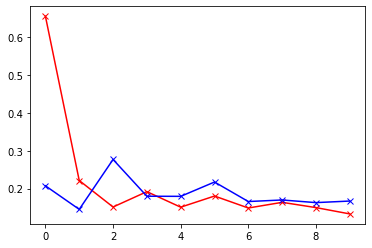

In [30]:
plt.plot(range(0, n_epochs), train_loss, 'rx-')
plt.plot(range(0, n_epochs), val_loss, 'bx-')

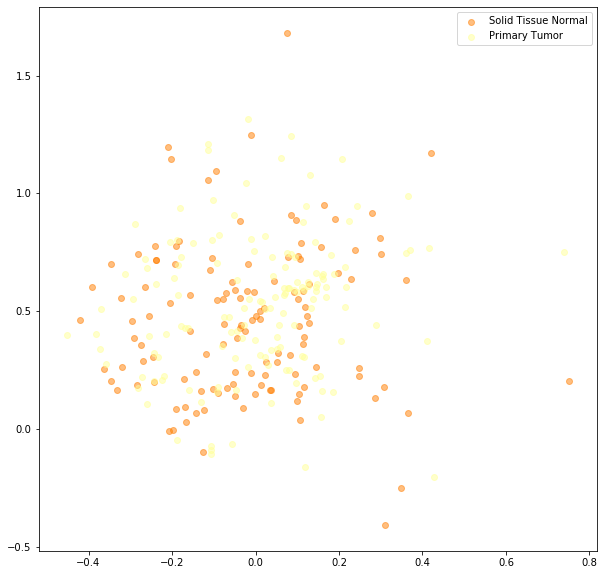

In [31]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_cl, train_labels_cl, siamese_train_dataset.labels_dict)

Frusturatingly the test_loader(shuffl=False) only works to load here because it has been specified for 1 sample at a time. The data order is the same as siamese_test_loader(shuffle=False).

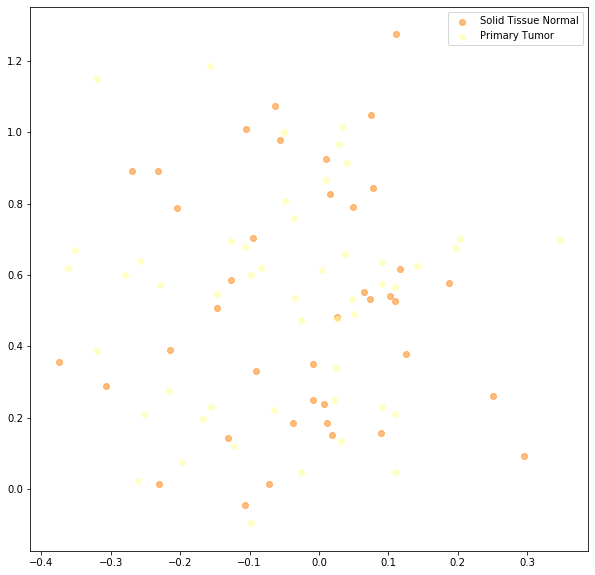

In [32]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_baseline, val_labels_baseline, siamese_test_dataset.labels_dict)

#### Write out test set for DE analysis

In [33]:
siamese_test_dataset.samples['label'] = siamese_test_dataset.labels
siamese_test_dataset.samples.to_pickle("../data/tmp/test_dataset_meta.pkl.gz")
siamese_test_dataset.data.to_pickle("../data/tmp/test_dataset.pkl.gz")

## Integrated Gradients
Test completeness axiom through comparison of different baselines

"Integrated gradients satisfy an
axiom called completeness that the attributions add up to
the difference between the output of F at the input x and
the baseline x'."

In [34]:
import copy
from captum.attr import LayerActivation
from captum.attr import IntegratedGradients

ignore matching samples by case ID in this experiment

because randomly shuffling the labels will not preserve

matched health/diseased samples for each case

not possible to test that with only 2 groups

In [41]:
def matched_pairs(SiameseTCGA, exp, ctrl):
    """
    Returns raw data from pairs of samples by case in test set.
    """
    gb = SiameseTCGA.samples.groupby('Sample Type')
    gb_splits = [gb.get_group(sample_type).sort_values(by='Case ID') for sample_type in gb.groups]
    assert np.array_equal(gb_splits[0]['Case ID'].values, gb_splits[1]['Case ID'].values), "Order of matched sample pairs not in sync."
    
    cases = gb_splits[0]['Case ID'].values
    
    ctrl_data = Variable(SiameseTCGA.test_data[gb.groups[ctrl]], requires_grad=True)
    exp_data = Variable(SiameseTCGA.test_data[gb.groups[exp]], requires_grad=True)
    
    return ctrl_data, exp_data, cases

In [51]:
def attribution_pairs(SiameseTCGA, exp, ctrl):
    # subset different samples
    negative_pairs = np.array(SiameseTCGA.test_pairs)
    negative_pairs = negative_pairs[negative_pairs[:,2] == 0]
    # map labels to integers
    ctrl = siamese_test_dataset.labels_dict[ctrl]
    exp = siamese_test_dataset.labels_dict[exp]
    # ordered indices of samples
    ctrl_data = [idx for pair in negative_pairs[:, :2] for idx in pair if np.isin(idx, SiameseTCGA.label_to_indices[ctrl])]
    exp_data = [idx for pair in negative_pairs[:, :2] for idx in pair if np.isin(idx, SiameseTCGA.label_to_indices[exp])]
    # data
    ctrl_data = Variable(SiameseTCGA.test_data[ctrl_data], requires_grad=True)
    exp_data = Variable(SiameseTCGA.test_data[exp_data], requires_grad=True)
    return ctrl_data, exp_data

# IG with Control vector

In [53]:
ctrl_data, exp_data = attribution_pairs(siamese_test_dataset, exp='Primary Tumor', ctrl='Solid Tissue Normal')

In [54]:
from torch.nn import PairwiseDistance
pdist = PairwiseDistance(p=2)
pdist

PairwiseDistance()

In [55]:
ig = IntegratedGradients(model.get_dist)

In [56]:
torch.cuda.empty_cache()

## Healthy as baseline

In [57]:
attr, delta = ig.attribute(exp_data.cuda(), ctrl_data.cuda(), target=None, n_steps=50, return_convergence_delta=True,
                          additional_forward_args=(ctrl_data.cuda(), pdist))
attr = attr.cpu().detach().numpy()
delta

tensor([ 4.9744e-04, -4.7120e-03, -2.3007e-03, -1.7159e-03,  1.2110e-02,
         9.0298e-04,  1.2867e-03, -5.3388e-03, -6.7519e-03,  9.9944e-03,
         3.6240e-04,  1.3106e-03, -4.7580e-03,  2.5266e-03,  1.1995e-04,
         2.5705e-04, -5.4261e-03,  3.3602e-03, -1.8729e-03,  4.0764e-04,
         6.5565e-05, -3.3930e-04,  4.1395e-05,  7.7325e-04,  8.6623e-04,
        -2.2620e-03,  2.3911e-02, -1.2619e-03, -5.9955e-03, -5.0966e-03,
        -5.6803e-04, -2.1401e-04, -2.8587e-03,  1.2904e-05,  5.5313e-05,
         5.2971e-04,  2.7160e-04, -3.4951e-03,  4.3221e-03, -2.9948e-04,
        -6.9487e-04, -1.4275e-04,  2.3124e-03,  3.1382e-04,  1.4367e-03],
       device='cuda:0')

In [58]:
attr.shape

(45, 18812)

## Average Protein Feature Attributions

In [59]:
proteins['ENSEMBL_ID'].values.shape
attr.shape[1]

(18842,)

18812

In [60]:
feat_imp = pd.DataFrame(data=attr.mean(axis=0), index=siamese_test_dataset.data.columns, columns=['Attribution'])
feat_imp.shape
feat_imp = pd.merge(feat_imp, proteins.drop_duplicates(subset='ENSEMBL_ID'), left_index=True, right_on='ENSEMBL_ID', how='left').sort_values(by='Attribution', ascending=False).reset_index(drop=True)
feat_imp.shape

(18812, 1)

(18812, 23)

In [61]:
feat_imp.to_pickle("../data/tmp/attr_avg.pkl.gz")

### Now go to /srv/home/wconnell/github/diffxpy/notebook/2020.02.05_test_DE_analysis and run

In [62]:
feat_imp[['Attribution', 'hgnc', 'Protein names', 'Gene ontology (biological process)', 'Gene ontology (molecular function)']]

,Attribution,hgnc,Protein names,Gene ontology (biological process),Gene ontology (molecular function)
0,0.001044,LHX3,LIM/homeobox protein Lhx3 (LIM homeobox protei...,animal organ morphogenesis [GO:0009887]; inner...,"DNA-binding transcription activator activity, ..."
1,0.000979,LCE1A,Late cornified envelope protein 1A (Late envel...,cornification [GO:0070268],NaN
2,0.000508,LCE2C,Late cornified envelope protein 2C (Late envel...,keratinization [GO:0031424],NaN
3,0.000390,CSN3,Kappa-casein,lactation [GO:0007595]; protein stabilization ...,NaN
4,0.000342,CCL1,C-C motif chemokine 1 (Small-inducible cytokin...,antimicrobial humoral immune response mediated...,CCR chemokine receptor binding [GO:0048020]; c...
...,...,...,...,...,...
18807,-0.000216,TMEM207,Transmembrane protein 207,NaN,enzyme binding [GO:0019899]
18808,-0.000339,TRIML1,Probable E3 ubiquitin-protein ligase TRIML1 (E...,multicellular organism development [GO:0007275...,metal ion binding [GO:0046872]; transferase ac...
18809,-0.000387,CRNN,Cornulin (53 kDa putative calcium-binding prot...,cell-cell adhesion [GO:0098609]; cellular resp...,calcium ion binding [GO:0005509]; transition m...
18810,-0.000589,OR4M1,Olfactory receptor 4M1 (Olfactory receptor OR1...,G protein-coupled receptor signaling pathway [...,G protein-coupled receptor activity [GO:000493...
